In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.color import rgb2lab, lab2rgb
from tqdm import tqdm
from typing import List, Dict, Tuple
from joblib import Parallel, delayed

from src.utils import *
from src.shape_align import *
from src.shape_utils import get_colorized_edge
from src.shape_utils import linearize_edge
from src.curvature import edge_coords2curvatures
from src.shape_align import water

In [2]:
data_dir = '../../dataset'
palette = np.array([[4.83058360e+01, -4.28336049e+00, -1.04226657e+00],
                    [7.28763389e+01,  1.10190913e+01,  2.91083397e+01],
                    [1.93975643e+01,  8.21757008e+00, -6.52862709e+00],
                    [6.12470461e+01,  6.38868771e+00,  1.05191202e+01],
                    [8.70237508e+01,  2.60029629e+00,  6.34060233e+00],
                    [3.84328672e+01,  2.22768163e+01,  1.17465682e+00],
                    [3.29131583e+01,  3.06846260e-02, -6.19825618e+00]])

In [3]:
frag1 = build_fragment_from_directory(data_dir + '/95')
frag2 = build_fragment_from_directory(data_dir + '/103')

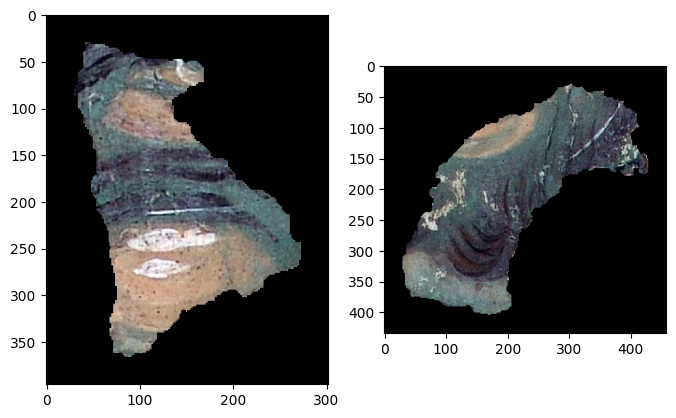

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,6))
axes[0].imshow(frag1.fragment)
axes[1].imshow(frag2.fragment)

In [39]:
frag_nums = [49, 53, 54]
frags = [pad_fragment_to_size(build_fragment_from_directory(data_dir + '/' + str(n)), 250) for n in frag_nums]

In [40]:
descriptors, alignment = new_pairwise_alignment(palette,frags, blocks_num=6)

Computing shape descriptors...
Computing pairwise alignments...
Aligning fragments 0 and 1:


100%|██████████████████████████████████████████████████████████████████████████████| 3694/3694 [00:10<00:00, 353.36it/s]


Aligning fragments 0 and 2:


100%|██████████████████████████████████████████████████████████████████████████████| 3694/3694 [00:12<00:00, 287.19it/s]


Aligning fragments 1 and 2:


100%|██████████████████████████████████████████████████████████████████████████████| 1346/1346 [00:04<00:00, 276.11it/s]


In [41]:
print(frag_nums)

[49, 53, 54]


In [62]:
l, r = 1, 2
align_i = 1
print(len(alignment[(l, r)]))

8


max curvature: [0.05790881]


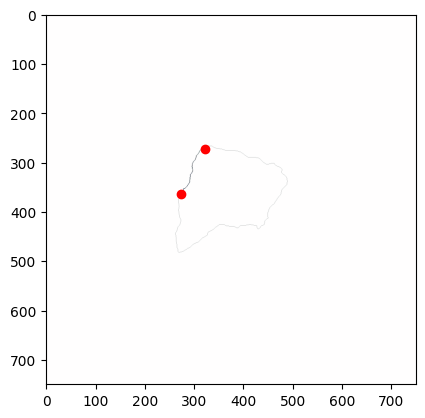

In [63]:
common_edge = np.ones(frags[l].fragment.shape)
color_edge, edge_coords, curvs = descriptors[l].color_edge, descriptors[l].edge_coords, descriptors[l].curvatures
indices = alignment[(l, r)][align_i].indices
# indices = aligns[align_i].indices
i_indices = [i for (i, j) in indices]
for i, point in enumerate(edge_coords):
    common_edge[point[0], point[1]] = 0.8
common_edge = rgb2lab(common_edge)

max_curvature = 0
for (i, j) in indices:
    color = color_edge[i - 1]
    y, x = edge_coords[i - 1]
    common_edge[y, x] = color
    if curvs[i - 1] > max_curvature:
        max_curvature = curvs[i - 1]
print(f"max curvature: {max_curvature}")

plt.imshow(lab2rgb(common_edge))
common_edge = lab2rgb(common_edge)
y1, x1 = edge_coords[indices[0][0] - 1]
y2, x2 = edge_coords[indices[-1][0] - 1]
plt.scatter([x1, x2], [y1, y2], color='r')
plt.imshow(common_edge)

max curvature: [0.04851551]


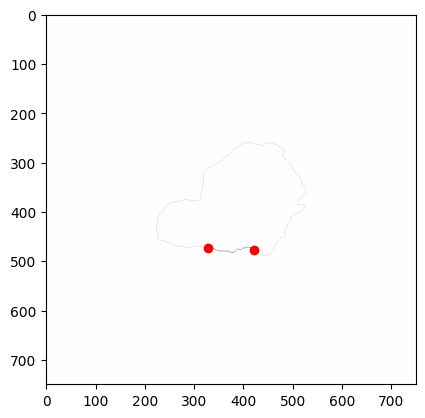

In [64]:
common_edge = np.ones(frags[r].fragment.shape)
color_edge, edge_coords, curvs = descriptors[r].color_edge[::-1], descriptors[r].edge_coords[::-1], descriptors[r].curvatures[::-1]
indices = alignment[(l, r)][align_i].indices
i_indices = [j for (i, j) in indices]
for i, point in enumerate(edge_coords):
    common_edge[point[0], point[1]] = 0.8
common_edge = rgb2lab(common_edge)
    
max_curvature = 0
for (i, j) in indices:
    color = color_edge[j - 1]
    y, x = edge_coords[j - 1]
    common_edge[y, x] = color

    if curvs[j - 1] > max_curvature:
        max_curvature = curvs[j - 1]
print(f"max curvature: {max_curvature}")
plt.imshow(lab2rgb(common_edge))
common_edge = lab2rgb(common_edge)
y1, x1 = edge_coords[indices[0][1] - 1]
y2, x2 = edge_coords[indices[-1][1] - 1]
plt.scatter([x1, x2], [y1, y2], color='r')
plt.imshow(common_edge)

## Visualizations for debug

In [24]:
def visualize_curvatures(shape_descriptor, fragment, l=0, r=1):
    curvs = shape_descriptor.curvatures
    edge_coords = shape_descriptor.edge_coords
    common_edge = np.ones(fragment.fragment.shape) * [0.1, 0.2, 0.1]
    top, bottom, left, right = edge_coords[:, 0].min(), edge_coords[:, 0].max(), edge_coords[:, 1].min(), edge_coords[:, 1].max()
    for i, point in enumerate(edge_coords):
        common_edge[point[0], point[1], 0] = 10 * (curvs[i] if l < curvs[i] < r  else 0)
        common_edge[point[0], point[1], 2] = - 10 * (curvs[i] if - l > curvs[i] > -r else 0)
        common_edge[point[0], point[1], 1] = 0
    return common_edge[top - 10:bottom + 10, left - 10:right + 10, :]

/tmp/ipykernel_502/4214348223.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  common_edge[point[0], point[1], 0] = 10 * (curvs[i] if l < curvs[i] < r  else 0)
/tmp/ipykernel_502/4214348223.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  common_edge[point[0], point[1], 2] = - 10 * (curvs[i] if - l > curvs[i] > -r else 0)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


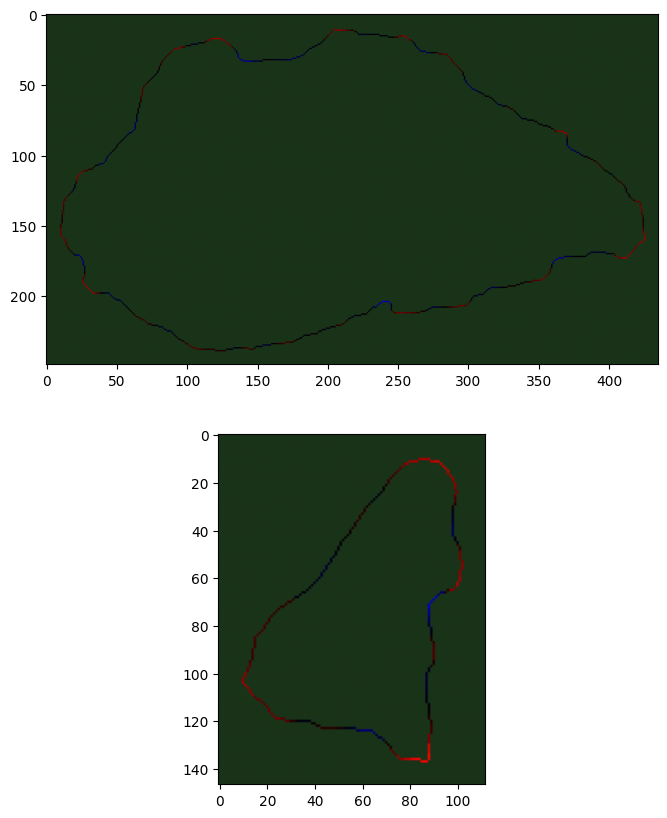

In [25]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

axes[0].imshow(visualize_curvatures(descriptors[l], frags[l]))
axes[1].imshow(visualize_curvatures(descriptors[r], frags[r]))